In [1]:
#Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import keras as kr
import sklearn as sk
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt

In [2]:
#Load the data from a CSV file, assuming it is downloaded in home folder
data_train = pd.read_csv(r"trainingdataset.csv", low_memory=False)
data_train_orig = data_train

In [3]:
data_train[' Label'] = data_train[' Label'].fillna('Normal')
data_train.head(5)

,Unnamed: 0,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,SimillarHTTP,Inbound,Label
0,425,172.16.0.5-192.168.50.1-634-60495-17,172.16.0.5,634,192.168.50.1,60495,17,2018-12-01 10:51:39.813448,28415,97,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,DrDoS_DNS
1,430,172.16.0.5-192.168.50.1-60495-634-17,192.168.50.1,634,172.16.0.5,60495,17,2018-12-01 10:51:39.820842,2,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,DrDoS_DNS
2,1654,172.16.0.5-192.168.50.1-634-46391-17,172.16.0.5,634,192.168.50.1,46391,17,2018-12-01 10:51:39.852499,48549,200,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,DrDoS_DNS
3,2927,172.16.0.5-192.168.50.1-634-11894-17,172.16.0.5,634,192.168.50.1,11894,17,2018-12-01 10:51:39.890213,48337,200,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,DrDoS_DNS
4,694,172.16.0.5-192.168.50.1-634-27878-17,172.16.0.5,634,192.168.50.1,27878,17,2018-12-01 10:51:39.941151,32026,200,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,DrDoS_DNS


In [4]:
print(data_train.dtypes)
data_train.shape

Unnamed: 0           int64
Flow ID             object
 Source IP          object
 Source Port         int64
 Destination IP     object
                    ...   
 Idle Max          float64
 Idle Min          float64
SimillarHTTP        object
 Inbound             int64
 Label              object
Length: 88, dtype: object


(5074413, 88)

In [5]:
# Strip leading and trailing spaces from column names
data_train.columns = data_train.columns.str.strip()

# Separate labels/ground truth
train_label_label = np.array(data_train['Label'].fillna('Normal'))  # Fill NaNs with 'Normal'
train_label_label_orig = train_label_label

# Remove labels from data
data_train = data_train.drop('Label', axis=1)

In [6]:
X = data_train.select_dtypes(include=[object])
X = X.drop('Source IP', axis=1)
X = X.drop('Destination IP', axis=1)
X.head(5)

,Flow ID,Timestamp,SimillarHTTP
0,172.16.0.5-192.168.50.1-634-60495-17,2018-12-01 10:51:39.813448,0
1,172.16.0.5-192.168.50.1-60495-634-17,2018-12-01 10:51:39.820842,0
2,172.16.0.5-192.168.50.1-634-46391-17,2018-12-01 10:51:39.852499,0
3,172.16.0.5-192.168.50.1-634-11894-17,2018-12-01 10:51:39.890213,0
4,172.16.0.5-192.168.50.1-634-27878-17,2018-12-01 10:51:39.941151,0


In [8]:
# Initialize the OneHotEncoder with sparse output
encoder = OneHotEncoder(sparse_output=True, handle_unknown='ignore')

# Fit and transform the data
X_sparse = encoder.fit_transform(X)

# Convert the result to a sparse DataFrame
X_sparse_df = pd.DataFrame.sparse.from_spmatrix(X_sparse, columns=encoder.get_feature_names_out())

In [9]:
#combine the data
data_wo_X = data_train
data_wo_X = data_wo_X.drop('Source IP', axis=1)
data_wo_X = data_wo_X.drop('Destination IP', axis=1)
data_wo_X.shape
frames = [data_wo_X, X]
data_train = pd.concat(frames, axis=1)
del data_wo_X
del X
del frames
del X_sparse
del X_sparse_df
data_train.head(5)
print(data_train.head())

   Unnamed: 0                               Flow ID  Source Port  \
0         425  172.16.0.5-192.168.50.1-634-60495-17          634   
1         430  172.16.0.5-192.168.50.1-60495-634-17          634   
2        1654  172.16.0.5-192.168.50.1-634-46391-17          634   
3        2927  172.16.0.5-192.168.50.1-634-11894-17          634   
4         694  172.16.0.5-192.168.50.1-634-27878-17          634   

   Destination Port  Protocol                   Timestamp  Flow Duration  \
0             60495        17  2018-12-01 10:51:39.813448          28415   
1             60495        17  2018-12-01 10:51:39.820842              2   
2             46391        17  2018-12-01 10:51:39.852499          48549   
3             11894        17  2018-12-01 10:51:39.890213          48337   
4             27878        17  2018-12-01 10:51:39.941151          32026   

   Total Fwd Packets  Total Backward Packets  Total Length of Fwd Packets  \
0                 97                       0             

In [10]:
# Use only top features
top_features = ['Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min']

# Ensure columns are stripped of any leading/trailing spaces
data_train.columns = data_train.columns.str.strip()

# Select the specified top features from the dataset
data_top = data_train[top_features]

# Assign the selected features to data_train
data_train = data_top

# Display the first 100 rows to verify
print(data_train.head(100))

    Flow Bytes/s  Flow Packets/s  Flow IAT Mean  Flow IAT Std  Flow IAT Max  \
0   1.502024e+06     3413.689952   2.959896e+02  5.009593e+02        3596.0   
1   4.400000e+08  1000000.000000   2.000000e+00  0.000000e+00           2.0   
2   1.812602e+06     4119.549321   2.439648e+02  5.781014e+02        5418.0   
3   1.820552e+06     4137.617146   2.428995e+02  4.852927e+02        3337.0   
4   2.747767e+06     6244.925998   1.609347e+02  1.968913e+02        1236.0   
..           ...             ...            ...           ...           ...   
95  2.092100e-01        0.428881   2.389943e+06  4.238069e+06    10019931.0   
96  1.185792e+06     2694.981944   3.729246e+02  4.221926e+02        1981.0   
97  5.337478e-01        0.439557   2.330506e+06  4.203258e+06    10009960.0   
98  2.094498e-01        0.429372   2.387207e+06  4.235329e+06    10018473.0   
99  1.149365e+06     2612.193720   3.847437e+02  4.346938e+02        1842.0   

    Flow IAT Min  
0            1.0  
1            

In [11]:
feature_list = list(data_train.columns)
feature_list
#convert to numpy array
#data_test = np.array(data_test)
data_train = np.array(data_train)

In [12]:
#transform string labels to values
from sklearn import preprocessing
lencoder = preprocessing.LabelEncoder()

lencoder.fit(train_label_label)

train_label_label = lencoder.transform(train_label_label)

#test_label_label = lencoder.transform(test_label_label)

print("Length of data_train:", len(data_train))
print("Length of train_label_label:", len(train_label_label))

# Verify lengths before splitting
length_data_train = len(data_train)
length_train_label_label = len(train_label_label)

print(f'Length of data_train: {length_data_train}')
print(f'Length of train_label_label: {length_train_label_label}')

# Diagnose and fix length mismatch
if length_data_train != length_train_label_label:
    print("Mismatch detected between data_train and train_label_label lengths.")
    
    # Check for any discrepancies in indices
    if length_data_train < length_train_label_label:
        print("data_train has fewer rows. Truncating train_label_label.")
        train_label_label = train_label_label[:length_data_train]
    else:
        print("train_label_label has fewer rows. Truncating data_train.")
        data_train = data_train.iloc[:length_train_label_label]

# Verify lengths again after truncation
print(f'Length of data_train (after possible truncation): {len(data_train)}')
print(f'Length of train_label_label (after possible truncation): {len(train_label_label)}')

Length of data_train: 5074413
Length of train_label_label: 5074413
Length of data_train: 5074413
Length of train_label_label: 5074413
Length of data_train (after possible truncation): 5074413
Length of train_label_label (after possible truncation): 5074413


In [13]:
# Some bug causes to have more columns in test data
# thus let's just work with train_data and split it

from sklearn.model_selection import train_test_split

# Verify lengths before splitting
if len(data_train) == len(train_label_label):
    data_train, data_test, train_labels, test_labels = train_test_split(data_train, train_label_label, test_size=0.25, random_state=50)
    print('Shapes:', data_test.shape, data_train.shape)
else:
    raise ValueError("Mismatch between data_train and train_label_label lengths. Cannot perform train_test_split.")


# Convert data_train to a DataFrame if it's a NumPy array
if isinstance(data_train, np.ndarray):
    data_train = pd.DataFrame(data_train)

# Check for infinite values and replace them with NaN
data_train.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the mean of the respective columns
data_train.fillna(data_train.mean(), inplace=True)

# Clip the values to a reasonable range to avoid extremely large values
data_train = data_train.clip(lower=np.finfo(np.float32).min, upper=np.finfo(np.float32).max)

# Convert back to NumPy array if necessary
data_train = data_train.values

# Verify lengths before splitting
length_data_train = len(data_train)
length_train_label_label = len(train_label_label)

print(f'Length of data_train: {length_data_train}')
print(f'Length of train_label_label: {length_train_label_label}')

# Diagnose and fix length mismatch
if length_data_train != length_train_label_label:
    print("Mismatch detected between data_train and train_label_label lengths.")
    
    # Check for any discrepancies in indices
    if length_data_train < length_train_label_label:
        print("data_train has fewer rows. Truncating train_label_label.")
        train_label_label = train_label_label[:length_data_train]
    else:
        print("train_label_label has fewer rows. Truncating data_train.")
        data_train = data_train[:length_train_label_label]

# Verify lengths again after truncation
print(f'Length of data_train (after possible truncation): {len(data_train)}')
print(f'Length of train_label_label (after possible truncation): {len(train_label_label)}')

Shapes: (1268604, 6) (3805809, 6)
Length of data_train: 3805809
Length of train_label_label: 5074413
Mismatch detected between data_train and train_label_label lengths.
data_train has fewer rows. Truncating train_label_label.
Length of data_train (after possible truncation): 3805809
Length of train_label_label (after possible truncation): 3805809


In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.feature_selection import SelectFromModel

# Initialize the RandomForestClassifier
rf = RandomForestClassifier(n_estimators=5, n_jobs=2, random_state=0, max_depth=10)

# Fit the RandomForest model
rf.fit(data_train, train_labels)

# Define the k-fold cross-validation configuration
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the RandomForestClassifier
rf = RandomForestClassifier(n_estimators=5, n_jobs=2, random_state=0, max_depth=10)

# Perform cross-validation and get the scores
cv_scores = cross_val_score(rf, data_train, train_label_label, cv=kf, scoring='accuracy')

# Print the cross-validation scores
print(f'Cross-validation scores: {cv_scores}')
print(f'Mean cross-validation score: {np.mean(cv_scores)}')
print(f'Standard deviation of cross-validation score: {np.std(cv_scores)}')

Cross-validation scores: [0.99932472 0.99939435 0.99934442 0.99932866 0.9993615 ]
Mean cross-validation score: 0.9993507293746934
Standard deviation of cross-validation score: 2.5385491556179653e-05


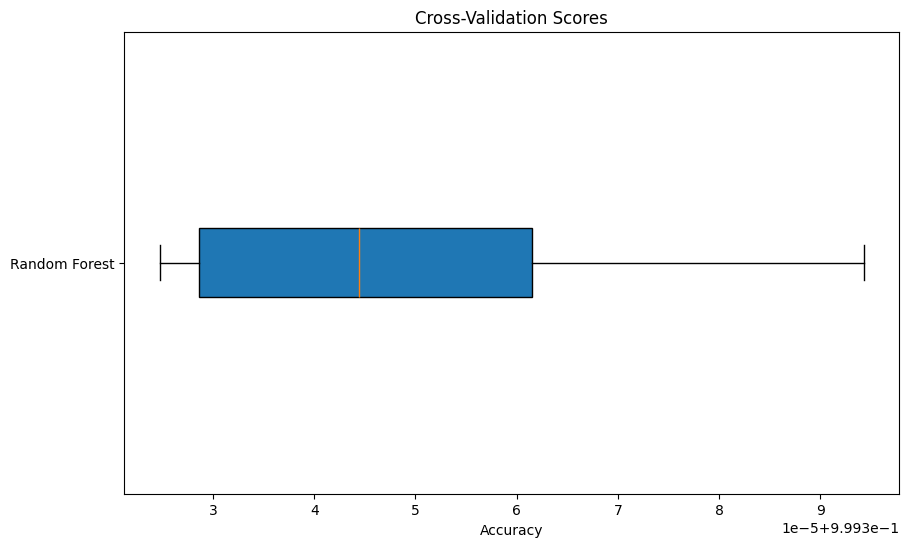

In [15]:
# Visualize the cross-validation scores with a box plot
plt.figure(figsize=(10, 6))
plt.boxplot(cv_scores, vert=False, patch_artist=True)
plt.title('Cross-Validation Scores')
plt.xlabel('Accuracy')
plt.yticks([1], ['Random Forest'])
plt.show()

In [16]:
# Ensure model is fitted before predictions
if not hasattr(rf, 'estimators_'):
    rf.fit(data_train, train_labels)

# Convert data_test to a DataFrame if it's a NumPy array
if isinstance(data_test, np.ndarray):
    data_test = pd.DataFrame(data_test)

# Check for infinite values and replace them with NaN
data_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the mean of the respective columns
data_test.fillna(data_test.mean(), inplace=True)

# Clip the values to a reasonable range to avoid extremely large values
data_test = data_test.clip(lower=np.finfo(np.float32).min, upper=np.finfo(np.float32).max)

# Convert back to NumPy array if necessary
data_test = data_test.values

# Predictions on test data
predictions = rf.predict(data_test)

# Calculate errors
errors = abs(predictions - test_labels)

# Mean absolute error
print('Mean Absolute error', round(np.mean(errors), 2), 'degrees')

Mean Absolute error 0.0 degrees


In [17]:
predictions

rf.predict_proba(data_test)[0:10]

# Create confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(test_labels, predictions)

array([[    697,     143],
       [     49, 1267715]], dtype=int64)

In [18]:
from sklearn.metrics import precision_recall_fscore_support

# Predictions on test data
predictions = rf.predict(data_test)

# Calculate precision, recall, and F1-score
precision, recall, f1_score, support = precision_recall_fscore_support(test_labels, predictions, zero_division=0)

print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1_score)
print('Support:', support)

# Calculate errors
errors = abs(predictions - test_labels)

# Mean absolute error
print('Mean Absolute error', round(np.mean(errors), 2), 'degrees')

Precision: [0.93431635 0.99988721]
Recall: [0.8297619  0.99996135]
F1 Score: [0.87894073 0.99992428]
Support: [    840 1267764]
Mean Absolute error 0.0 degrees


In [19]:
# Calculate precision, recall, and F1-score with zero_division parameter
precision, recall, f1_score, support = precision_recall_fscore_support(test_labels, predictions, average='macro', zero_division=0)

print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1_score)
print('Support:', support)

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / (test_labels+1))

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Precision: 0.9671017826156283
Recall: 0.9148616270175567
F1 Score: 0.9394325051670342
Support: None
Accuracy: 99.99 %.


Variable: Flow Bytes/s         Importance: 0.38
Variable: Flow IAT Mean        Importance: 0.26
Variable: Flow IAT Std         Importance: 0.13
Variable: Flow IAT Max         Importance: 0.11
Variable: Flow Packets/s       Importance: 0.1
Variable: Flow IAT Min         Importance: 0.02


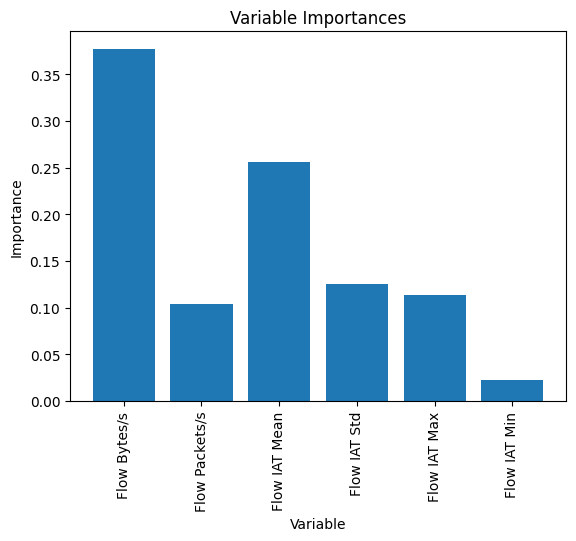

In [20]:
# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')

# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

In [21]:
list(zip(data_train, rf.feature_importances_))

[(array([2.944e+09, 2.000e+06, 1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00]),
  0.37705535283174596),
 (array([2.944e+09, 2.000e+06, 1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00]),
  0.10438216969208261),
 (array([2.896e+09, 2.000e+06, 1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00]),
  0.256572072167365),
 (array([1.472e+09, 1.000e+06, 2.000e+00, 0.000e+00, 2.000e+00, 2.000e+00]),
  0.12544932991352495),
 (array([2.944e+09, 2.000e+06, 1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00]),
  0.11342287595254269),
 (array([7.e+07, 2.e+06, 1.e+00, 0.e+00, 1.e+00, 1.e+00]),
  0.023118199442738994)]

In [22]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(data_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

print('Number of features:', rf.n_features_in_)

Feature ranking:
1. feature 0 (0.377055)
2. feature 2 (0.256572)
3. feature 3 (0.125449)
4. feature 4 (0.113423)
5. feature 1 (0.104382)
6. feature 5 (0.023118)
Number of features: 6


In [23]:
# Assuming train_label_label_orig contains the original category labels

# Check category-wise performance using the original labels
unique_categories, counts = np.unique(train_label_label_orig, return_counts=True)
category_distribution = pd.DataFrame({'Category': unique_categories, 'Count': counts})

print(category_distribution)

    Category    Count
0     BENIGN     3402
1  DrDoS_DNS  5071011


In [24]:
from sklearn import tree
from sklearn.tree import export_text
i_tree = 0
for tree_in_forest in rf.estimators_:
    with open('tree_' + str(i_tree) + '.dot', 'w') as my_file:
        my_file = tree.export_graphviz(tree_in_forest, out_file = my_file)
        r = export_text(tree_in_forest)
        print("TREE ", i_tree)
        print(r)  
    i_tree = i_tree + 1

TREE  0
|--- feature_0 <= 41394.96
|   |--- feature_4 <= 92905.00
|   |   |--- feature_2 <= 3159.51
|   |   |   |--- feature_4 <= 628.50
|   |   |   |   |--- feature_1 <= 13363.10
|   |   |   |   |   |--- feature_3 <= 47.63
|   |   |   |   |   |   |--- feature_5 <= 207.00
|   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |--- feature_5 >  207.00
|   |   |   |   |   |   |   |--- feature_1 <= 9456.32
|   |   |   |   |   |   |   |   |--- feature_4 <= 242.50
|   |   |   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |   |   |--- feature_4 >  242.50
|   |   |   |   |   |   |   |   |   |--- feature_4 <= 262.00
|   |   |   |   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |   |   |   |--- feature_4 >  262.00
|   |   |   |   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |   |--- feature_1 >  9456.32
|   |   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |--- feature_3 >  47.63
|   |   |   |   |   |   |--- featu

In [25]:
import pickle as pickle
filename = r'rf_model.sav'
pickle.dump(rf, open(filename, 'wb'))

In [26]:
one_hot_train_label_label_orig = pd.get_dummies(train_label_label_orig)
one_hot_train_label_label_orig.describe()
print(one_hot_train_label_label_orig.sum(axis=0))

BENIGN          3402
DrDoS_DNS    5071011
dtype: int64


In [27]:
precision_recall_fscore_support(test_labels, predictions, average='macro')

(0.9671017826156283, 0.9148616270175567, 0.9394325051670342, None)

In [28]:
import os
print("Current working directory:", os.getcwd())
print(f"Model saved to {os.path.abspath(filename)}")

Current working directory: C:\Users\usama\Documents\DDoS_Dataset\D2\01-12
Model saved to C:\Users\usama\Documents\DDoS_Dataset\D2\01-12\udp_rf_model_5trees.sav


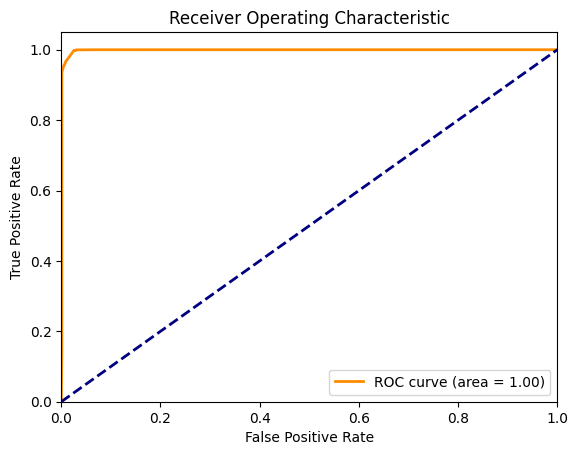

In [29]:
from sklearn.metrics import roc_curve, roc_auc_score
y_pred_proba = rf.predict_proba(data_test)[:, 1]  # Probability of the positive class
fpr, tpr, thresholds = roc_curve(test_labels, y_pred_proba)
roc_auc = roc_auc_score(test_labels, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Class distribution in the training data:
Class 0: 2470 samples
Class 1: 3803339 samples


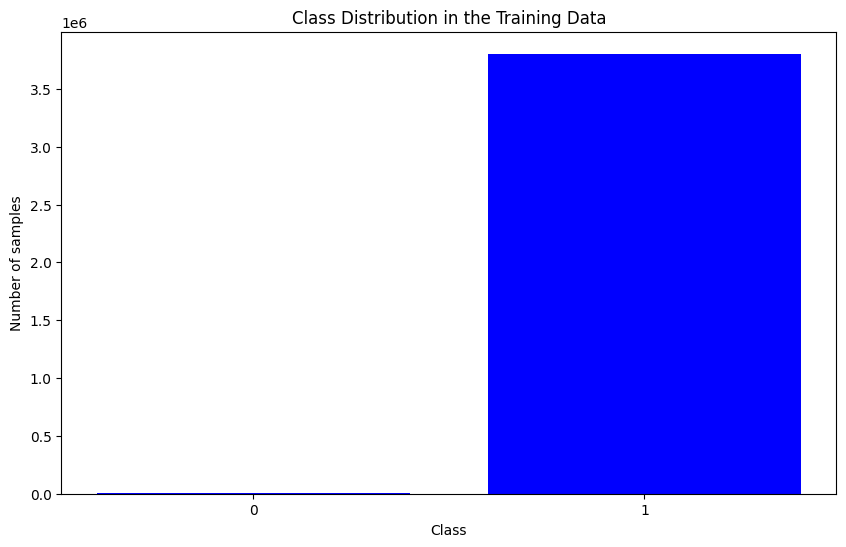

In [30]:
# Check for Class Imbalance
unique, counts = np.unique(train_label_label, return_counts=True)
class_distribution = dict(zip(unique, counts))

print("Class distribution in the training data:")
for cls, count in class_distribution.items():
    print(f"Class {cls}: {count} samples")

# Visualize the class distribution
plt.figure(figsize=(10, 6))
plt.bar(class_distribution.keys(), class_distribution.values(), color='blue')
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.title('Class Distribution in the Training Data')
plt.xticks(list(class_distribution.keys()))
plt.show()